In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import itertools
import numpy
import nltk
import matplotlib.pyplot
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import os
import pandas
import seaborn
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import re as regularExpression
from warnings import simplefilter
simplefilter("ignore", category=ConvergenceWarning)

nltk.download('stopwords')
hermesDataDirectoryFolder = '/kaggle/input/fake-and-real-news-dataset/'
mercuryDataDirectoryFolder = '/kaggle/input/fake-news/'

stopwords = set(nltk.corpus.stopwords.words('english'))

trueDataNews = pandas.read_csv(hermesDataDirectoryFolder + 'True.csv')
falseDataNews = pandas.read_csv(hermesDataDirectoryFolder + 'Fake.csv')
falseMercuryDataNews = pandas.read_csv(mercuryDataDirectoryFolder + 'fake.csv')
englishMercuryDataNews = falseMercuryDataNews.loc[(falseMercuryDataNews['language'] == 'english') & (falseMercuryDataNews['title'].notna())]

trueDataNews['class'] = 1
falseDataNews['class'] = 0
allNewsData = pandas.concat([trueDataNews, falseDataNews])

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/fake-news/fake.csv


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
trueDataNews.head()

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [3]:
trueDataNews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   class    21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


In [4]:
falseDataNews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   class    23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


In [5]:
englishMercuryDataNews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11723 entries, 0 to 12912
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uuid                11723 non-null  object 
 1   ord_in_thread       11723 non-null  int64  
 2   author              9514 non-null   object 
 3   published           11723 non-null  object 
 4   title               11723 non-null  object 
 5   text                11677 non-null  object 
 6   language            11723 non-null  object 
 7   crawled             11723 non-null  object 
 8   site_url            11723 non-null  object 
 9   country             11547 non-null  object 
 10  domain_rank         7662 non-null   float64
 11  thread_title        11723 non-null  object 
 12  spam_score          11723 non-null  float64
 13  main_img_url        8286 non-null   object 
 14  replies_count       11723 non-null  int64  
 15  participants_count  11723 non-null  int64  
 16  like

In [6]:
def intersectNewsSubjects(lhsData, rhsData):
    return numpy.intersect1d(lhsData.subject.unique(), rhsData.subject.unique())

def removeNoisyData(data, numberOfWords):
    corpus = []
    for i in range(0, numberOfWords):
        document = regularExpression.sub('[^a-zA-Z]', ' ', data[i])
        document = document.lower()
        document = document.split()
        porterStemmer = PorterStemmer()
        document = [porterStemmer.stem(word) for word in document if not word in set(stopwords)]
        document = ' '.join(document) 
        corpus.append(document)
    return corpus

In [7]:

def plotAllDataNews():
    matplotlib.pyplot.close()
    seaborn.countplot(allNewsData, x='class')
    matplotlib.pyplot.show()

## TODO::order the x label to be under the y-label 
def plotNewsSubject():
    matplotlib.pyplot.close()
    matplotlib.pyplot.figure(figsize=(16,8))
    chart=seaborn.countplot(x='subject', hue='class', data=allNewsData, linewidth=10)
    matplotlib.pyplot.show()

## TODO::order the x label to be under the y-label 
def plotFalseNewsSubject():
    matplotlib.pyplot.close()
    matplotlib.pyplot.figure(figsize=(16,8))
    chart=seaborn.countplot(x='subject',  data=falseDataNews, linewidth=10)
    matplotlib.pyplot.show()

## TODO::order the x label to be under the y-label 
def plotTrueNewsSubject():
    matplotlib.pyplot.close()
    matplotlib.pyplot.figure(figsize=(16,8))
    chart=seaborn.countplot(x='subject',  data=trueDataNews, linewidth=10)
    matplotlib.pyplot.show()

def plot_confusion_matrix(correctTargetValues, estimatedTargetValues, classes, bNormalizeConfusionMatrix=False, title='Confusion Matrix', colourMap=matplotlib.pyplot.cm.Blues, figureSize=(9,7)):
    matrix = confusion_matrix(correctTargetValues, estimatedTargetValues)

    if bNormalizeConfusionMatrix:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, numpy.newaxis]
    
    matplotlib.pyplot.close()
    matplotlib.pyplot.imshow(matrix, interpolation='nearest', cmap=colourMap)
    matplotlib.pyplot.title(title)

    tickMarks = numpy.arange(len(classes))
    matplotlib.pyplot.xticks(tickMarks, classes, rotation=45)
    matplotlib.pyplot.yticks(tickMarks, classes)

    fmt= '.2f' if bNormalizeConfusionMatrix else 'd'
    threshold = matrix.max() / 2.0
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        matplotlib.pyplot.text(j, i, format(matrix[i,j], fmt),
            horizontalalignment='center',
            size=int((figureSize[0] / 10) * 38),
            color='white' if matrix[i,j] > threshold else 'black')
    
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.ylabel('True label')
    matplotlib.pyplot.xlabel('Predicted lable')
    matplotlib.pyplot.show()
    
def plotClassifierResult(yExpected, yPredicted, classes, confusionMatrixTitle="Confusion Matrix"):
    print(accuracy_score(yExpected, yPredicted))
    plot_confusion_matrix(yExpected, yPredicted, classes=classes, title=confusionMatrixTitle)
    plot_confusion_matrix(yExpected, yPredicted, classes=classes, bNormalizeConfusionMatrix=True, title=confusionMatrixTitle)

    

0.9286965818311407


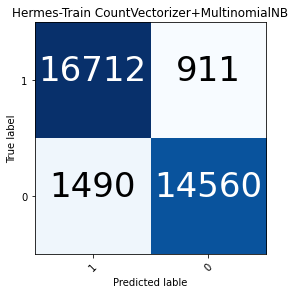

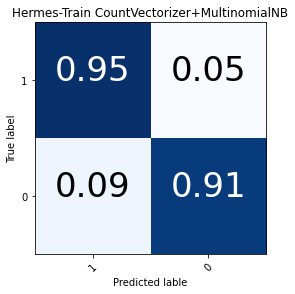

0.9316703786191537


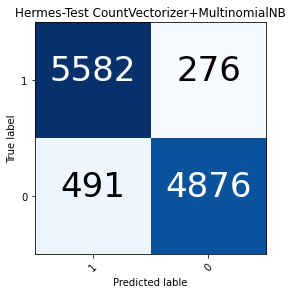

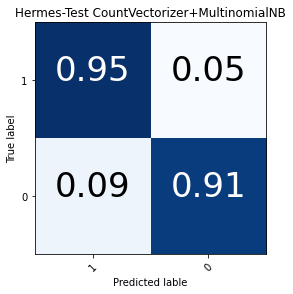

0.6863430862407234


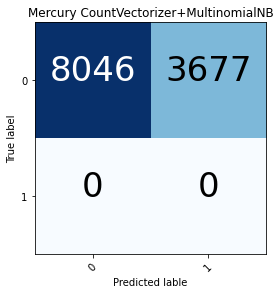

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


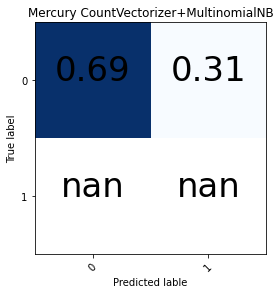

In [8]:

numberOfWords = len(allNewsData['title'].values)
corpus = removeNoisyData(allNewsData['title'].values, numberOfWords)

countVectorizer = CountVectorizer(max_features=10000)
X = countVectorizer.fit_transform(corpus).toarray()
y = allNewsData['class'].values[:numberOfWords]
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=0)
classifier = MultinomialNB(alpha=0.01)
# crossValueScoreResult = cross_val_score(classifier, xTrain, yTrain, cv=3, n_jobs=6)
predictionTrainY = cross_val_predict(classifier, xTrain, yTrain, cv=3, n_jobs=6)
classifier.fit(xTrain, yTrain)
predictTestY = classifier.predict(xTest)

plotClassifierResult(yTrain, predictionTrainY, allNewsData['class'].unique(), confusionMatrixTitle="Hermes-Train CountVectorizer+MultinomialNB")
plotClassifierResult(yTest, predictTestY, allNewsData['class'].unique(),  confusionMatrixTitle="Hermes-Test CountVectorizer+MultinomialNB")

mercuryCorpus = removeNoisyData(englishMercuryDataNews['title'].values, len(englishMercuryDataNews['title'].values))
X_MercuryCorpus = countVectorizer.fit_transform(mercuryCorpus).toarray()

mercuryPrediction = classifier.predict(X_MercuryCorpus)
zeros = numpy.zeros(len(X_MercuryCorpus))
plotClassifierResult(zeros, mercuryPrediction, numpy.flip(allNewsData['class'].unique()), confusionMatrixTitle="Mercury CountVectorizer+MultinomialNB")

0.9289935556677457


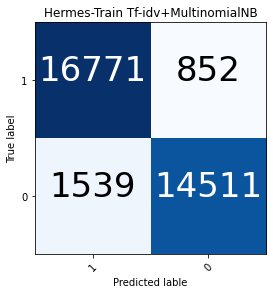

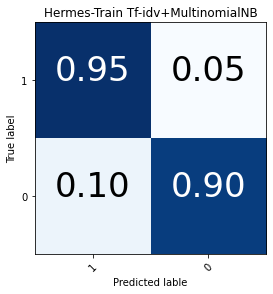

0.9327394209354121


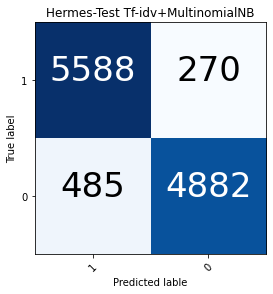

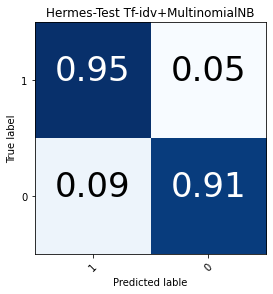

0.7453723449628935


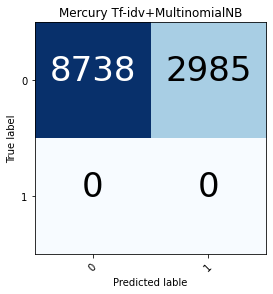

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


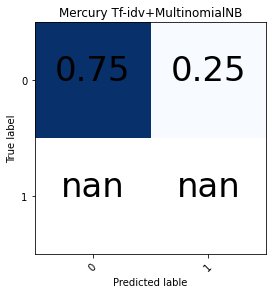

In [9]:
numberOfWords = len(allNewsData['title'].values)
corpus = removeNoisyData(allNewsData['title'].values, numberOfWords)

countVectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3), lowercase=False)
X = countVectorizer.fit_transform(corpus).toarray()
y = allNewsData['class'].values[:numberOfWords]
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=0)
classifier = MultinomialNB(alpha=0.01)
# crossValueScoreResult = cross_val_score(classifier, xTrain, yTrain, cv=3, n_jobs=6)
predictionTrainY = cross_val_predict(classifier, xTrain, yTrain, cv=3, n_jobs=6)
classifier.fit(xTrain, yTrain)
predictTestY = classifier.predict(xTest)

plotClassifierResult(yTrain, predictionTrainY, allNewsData['class'].unique(), confusionMatrixTitle="Hermes-Train Tf-idv+MultinomialNB")
plotClassifierResult(yTest, predictTestY, allNewsData['class'].unique(), confusionMatrixTitle="Hermes-Test Tf-idv+MultinomialNB")

mercuryCorpus = removeNoisyData(englishMercuryDataNews['title'].values, len(englishMercuryDataNews['title'].values))
X_MercuryCorpus = countVectorizer.fit_transform(mercuryCorpus).toarray()

mercuryPrediction = classifier.predict(X_MercuryCorpus)
zeros = numpy.zeros(len(X_MercuryCorpus))
plotClassifierResult(zeros, mercuryPrediction, numpy.flip(allNewsData['class'].unique()), confusionMatrixTitle="Mercury Tf-idv+MultinomialNB")